<a href="https://colab.research.google.com/github/sarankumar1325/CREDIT-CARD-ANOMALY-DETECTION/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Dependancies**

In [2]:
!pip install numpy pandas matplotlib seaborn scikit-learn scipy

**Import Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.stats import zscore
from scipy.spatial.distance import mahalanobis
import warnings
warnings.filterwarnings('ignore')

**Data loading and preprocessing**

In [4]:
# Load data
df = pd.read_csv('/content/creditcard.csv')

# Select features (excluding Class and Time)
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'Amount']
X = df[features]
y = df['Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Check the first few rows of the dataset
X_scaled.head()


,V1,V2,V3,V4,V5,Amount
0,-0.611556,-0.046512,1.459060,0.930937,-0.040135,0.229496
1,0.788049,0.162514,-0.400857,0.230665,0.262612,-0.357756
2,-0.610759,-0.828129,0.860135,0.179180,-0.165446,1.144927
3,-0.395700,-0.115858,0.875662,-0.756827,0.209162,0.125099
4,-0.500992,0.539690,0.683950,0.196690,-0.092480,-0.088770


**Z-score anomaly detection**

In [5]:
# Detect anomalies using Z-score method
threshold = 3
z_scores = np.abs(zscore(X_scaled))
outlier_mask_zscore = (z_scores > threshold).any(axis=1)

In [6]:
# View Z-score outliers
outlier_mask_zscore[:10]

,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


**Mahalanobis distance anomaly detection**

In [7]:
# Detect anomalies using Mahalanobis distance
mean = np.mean(X_scaled, axis=0)
cov = np.cov(X_scaled.T)
inv_covmat = np.linalg.inv(cov)

In [8]:
mahal_dist = []
for i in range(X_scaled.shape[0]):
    x = X_scaled.iloc[i]
    dist = mahalanobis(x, mean, inv_covmat)
    mahal_dist.append(dist)

In [9]:
threshold_mahalanobis = 20
outlier_mask_mahalanobis = np.array(mahal_dist) > threshold_mahalanobis

In [10]:
# View Mahalanobis distance outliers
outlier_mask_mahalanobis[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

**Local Outlier Factor (LOF) anomaly detection**

In [13]:
# Remove rows with missing values
X_scaled_clean = X_scaled.dropna()

# Run Local Outlier Factor again on the clean data
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = lof.fit_predict(X_scaled_clean)
outlier_mask_lof = y_pred_lof == -1

In [14]:
# View LOF outliers
outlier_mask_lof[:10]

array([False, False, False, False, False, False, False,  True, False,
        True])

**One-Class SVM anomaly detection**

In [16]:
# Detect anomalies using One-Class SVM
svm = OneClassSVM(kernel='rbf', nu=0.1)
y_pred_svm = svm.fit_predict(X_scaled_clean)
outlier_mask_svm = y_pred_svm == -1

# View One-Class SVM outliers
outlier_mask_svm[:10]


array([False, False, False, False, False, False, False, False, False,
       False])

**Evaluation**

In [19]:
# Define the evaluation function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_detector(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

# Remove any NaNs from `y` to match the cleaned data
y_clean = y.dropna()

# Ensure `X_scaled` and `y` have the same length
X_scaled_clean = X_scaled.dropna().loc[y_clean.index]

# Update `outlier_mask_zscore` for the cleaned dataset
z_scores_clean = np.abs(zscore(X_scaled_clean))
outlier_mask_zscore_clean = (z_scores_clean > threshold).any(axis=1)

# Evaluate Z-score detection
eval_zscore = evaluate_detector(y_clean, outlier_mask_zscore_clean)
eval_zscore

{'Accuracy': 0.9618776500003765,
 'Precision': 0.03216374269005848,
 'Recall': 0.6297709923664122,
 'F1-Score': 0.061201780415430264}

**Visualisation of Results**

In [23]:
# Option 1: Fill NaN values with the mean of each column
X_scaled.fillna(X_scaled.mean(), inplace=True)

In [24]:
# Z-Score Method
threshold = 3
z_scores = np.abs(zscore(X_scaled))
outlier_mask_zscore = (z_scores > threshold).any(axis=1)

# Mahalanobis Distance
from scipy.spatial.distance import mahalanobis
mean = np.mean(X_scaled, axis=0)
cov = np.cov(X_scaled.T)
inv_covmat = np.linalg.inv(cov)
mahal_dist = [mahalanobis(X_scaled.iloc[i], mean, inv_covmat) for i in range(X_scaled.shape[0])]
outlier_mask_mahalanobis = np.array(mahal_dist) > 20

# Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = lof.fit_predict(X_scaled)
outlier_mask_lof = y_pred_lof == -1

# Isolation Forest
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred_isoforest = iso_forest.fit_predict(X_scaled)
outlier_mask_isoforest = y_pred_isoforest == -1

# One-Class SVM
from sklearn.svm import OneClassSVM
svm = OneClassSVM(kernel='rbf', nu=0.1)
y_pred_svm = svm.fit_predict(X_scaled)
outlier_mask_svm = y_pred_svm == -1

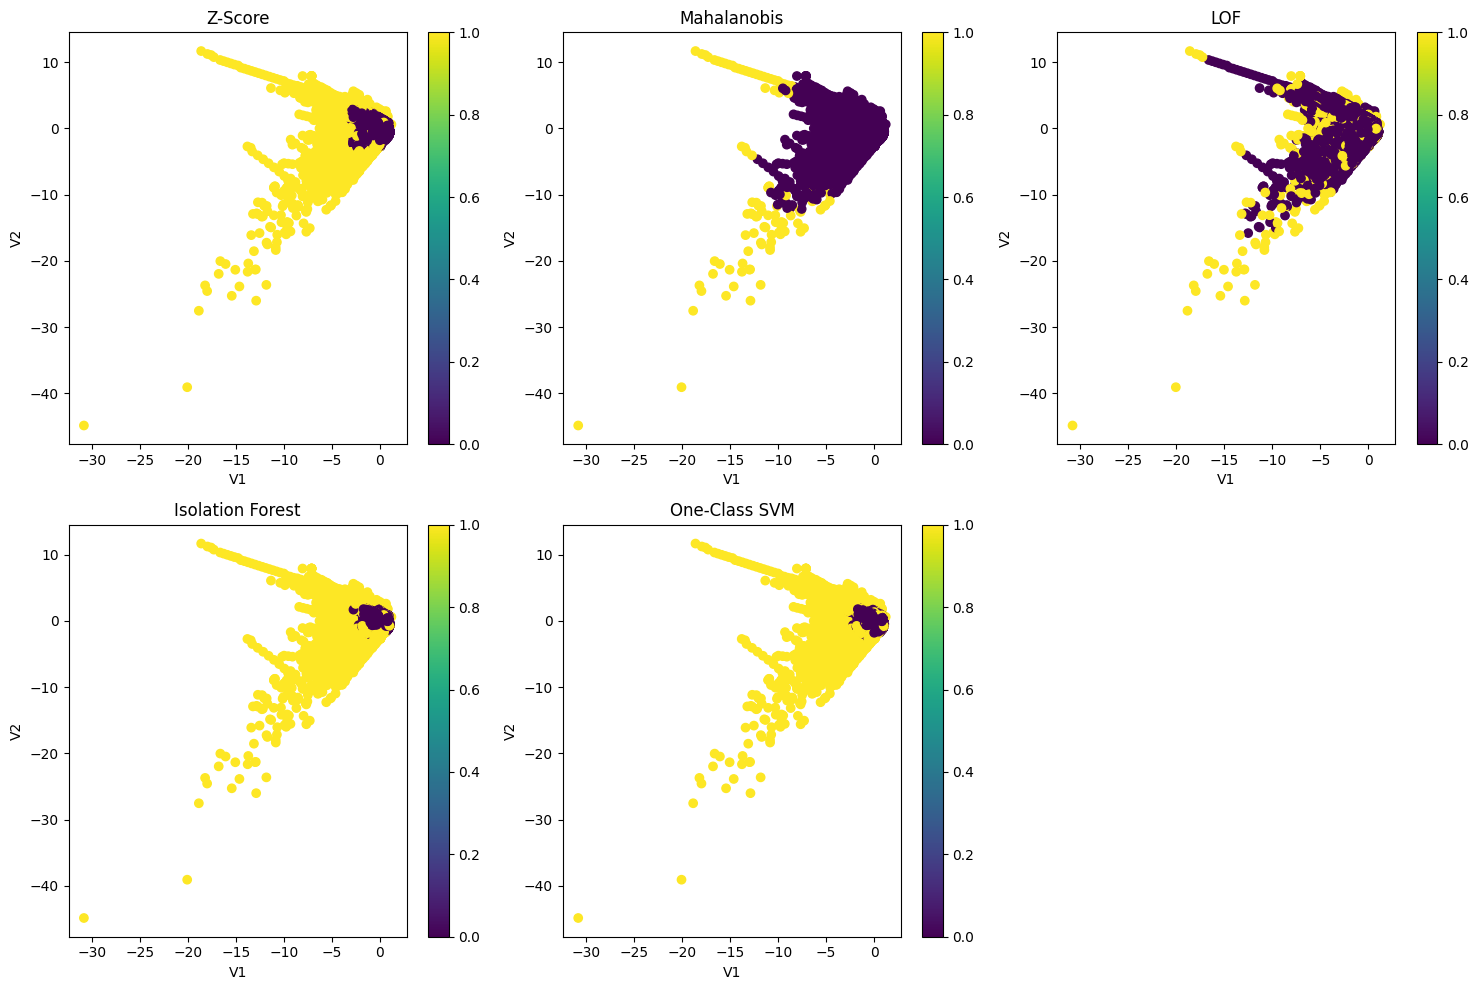

In [26]:
# Visualize the results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# List of outlier masks and corresponding method names
methods = [outlier_mask_zscore, outlier_mask_mahalanobis, outlier_mask_lof, outlier_mask_isoforest, outlier_mask_svm]
method_names = ['Z-Score', 'Mahalanobis', 'LOF', 'Isolation Forest', 'One-Class SVM']

# Plotting only for the five methods we have
for idx, (method, name) in enumerate(zip(methods, method_names)):
    scatter = axes[idx].scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c=method, cmap='viridis')
    axes[idx].set_title(name)
    axes[idx].set_xlabel('V1')
    axes[idx].set_ylabel('V2')
    plt.colorbar(scatter, ax=axes[idx])

# Remove the sixth blank subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()